imports

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

loading dataset, standardising, calculating co-varince matrix, computing eigenvalues and sorting them

In [16]:
df = pd.read_csv('/Users/prabhpreet16/Downloads/IML2/Country-data.csv')

features = ['child_mort', 'health', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']
X = df[features]

# Standardize (mean=0, std=1)
X_standardized = (X - X.mean()) / X.std()

cov_matrix = np.cov(X_standardized.T)

eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Sort in descending order
sorted_idx = np.argsort(eigenvalues)[::-1]
eigenvalues_sorted = eigenvalues[sorted_idx]
eigenvectors_sorted = eigenvectors[:, sorted_idx]

explained_variance_ratio = eigenvalues_sorted / np.sum(eigenvalues_sorted)

explained_variance_ratio


array([0.54853415, 0.15406463, 0.14181252, 0.1004432 , 0.03259373,
       0.01280763, 0.00974414])

Now, for minimum principal components required to explain 80% of data, we add the explained_variance ratios until we get 0.8

In [15]:



def minPCA (e_v_ratio):
    viabile_ratio=0.0
    for i, ratio in enumerate(e_v_ratio):
    
        viabile_ratio+=ratio
        if (viabile_ratio>0.8):
            break
    return i+1

print("The minimum number of principal components needed to explain at least 80% of the variability is:", minPCA(explained_variance_ratio))    




PC1: 0.5485
PC2: 0.1541
PC3: 0.1418
The minimum number of principal components needed to explain at least 80% of the variability is: 3


Now, we display a scatterplot of the first two PCs

In [35]:
X_np = X_standardized.to_numpy()

X_pca_2d = X_np @ eigenvectors_sorted[:, :2]

df_pca_2d = pd.DataFrame(X_pca_2d, columns=['PC1', 'PC2'])

df_pca_2d

,PC1,PC2
0,-2.716300,0.756076
1,0.601770,0.106854
2,-0.166475,-1.195099
3,-3.335440,-1.286836
4,0.958376,-0.005687
...,...,...
162,-0.971129,0.278057
163,-0.232887,-2.939392
164,-0.024912,-0.129343
165,-1.781273,-1.028974


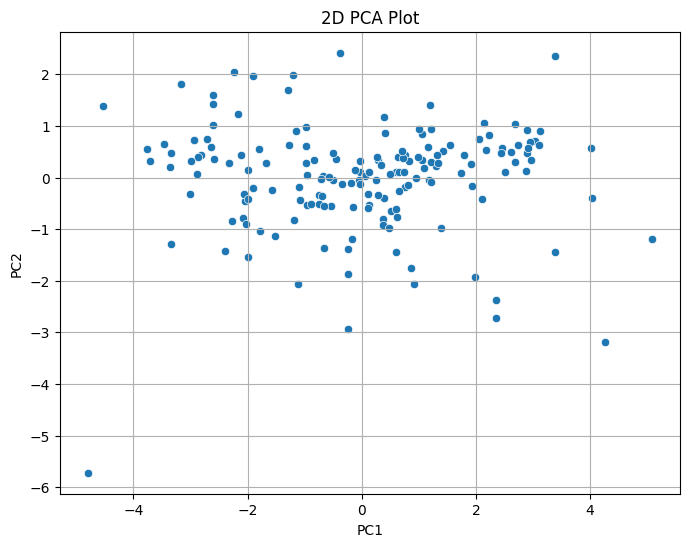

In [36]:
# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca_2d, x='PC1', y='PC2')
plt.title("2D PCA Plot")
plt.grid(True)
plt.show()


Now, we apply k-means to this reduced data

In [37]:


def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def initialize_centroids(X, k):
    np.random.seed()
    indices = np.random.choice(X.shape[0], k, replace=False) #randomly chossing 4 unique datapoints as centroids
    return X[indices]

def assign_clusters(X, centroids):

    cluster_assignments = []

    for point in X:
        distances = []
        
        # Calculate distance from the point to each centroid
        for centroid in centroids:
            distance = euclidean_distance(point, centroid)
            distances.append(distance)
        
        # Find the index of the closest centroid
        closest_cluster = np.argmin(distances)
        
        # Assign the point to that cluster
        cluster_assignments.append(closest_cluster)

    # Return the final cluster labels
    return np.array(cluster_assignments)


def update_centroids(X, clusters, k):
    new_centroids = []
    for i in range(k):
        points = X[clusters == i]
        if len(points) == 0:  # empty cluster
            new_centroids.append(X[np.random.randint(0, X.shape[0])]) # then assign a new data point as a cluster randomly
        else:
            new_centroids.append(points.mean(axis=0)) # else take the mean of the cluster as the new centroid
    return np.array(new_centroids)


def compute_distortion(X, labels, centroids):
    distortion = 0
    for i in range(len(X)):
        centroid = centroids[labels[i]] 
        distortion += np.linalg.norm(X[i] - centroid) ** 2  # total distorition calculated from every point
    return distortion

def kmeans(X, k=4, max_iters=100): #capping iterations at 100
    centroids = initialize_centroids(X, k) #randomly initialising
    
    for i in range(max_iters):
        clusters = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, clusters, k)
        
            
        centroids = new_centroids
    
    return clusters, centroids

In [39]:
best_labels = None
best_centroids = None
lowest_distortion = float('inf')

for i in range(5):
    print(f"\nInitialization {i+1}:")
    
    clusters, centroids = kmeans(X_pca_2d, k=4)
    

    
    # Show cluster labels for current run
    print("Cluster Labels:\n", clusters)
    
    # Show centroid coordinates for current run
    print("Centroids (in standardized feature space):\n", centroids)
    
    # Show distortion for current run
    distortion = compute_distortion(X_pca_2d, clusters, centroids) 
    print(f"Run {i+1} Distortion: {distortion:.2f}") 
    
    if distortion < lowest_distortion: # min distortion calculation
        lowest_distortion = distortion
        best_labels = clusters
        best_centroids = centroids

print("\n Best clustering selected with lowest distortion.")
lowest_distortion


Initialization 1:
Cluster Labels:
 [0 1 1 2 1 1 1 3 3 1 1 1 1 1 1 3 1 2 1 1 1 0 1 3 1 0 0 0 0 3 1 2 2 1 1 1 0
 2 2 1 2 1 3 3 3 1 1 1 1 2 2 1 1 3 3 2 0 1 3 2 3 1 1 2 0 1 2 1 3 1 1 1 0 3
 3 3 1 3 1 1 0 0 3 1 2 1 1 0 0 1 1 3 1 2 2 1 1 2 3 2 1 0 1 2 1 1 2 2 0 1 3
 3 2 2 3 1 2 1 1 1 1 1 3 3 1 1 0 1 1 0 1 1 0 3 3 3 0 0 3 3 1 1 2 1 3 3 0 2
 1 2 0 1 1 1 1 0 1 3 3 3 1 1 0 1 1 2 2]
Centroids (in standardized feature space):
 [[-1.77376023  0.97346717]
 [ 0.31674953 -0.16708638]
 [-2.61191647 -0.48373411]
 [ 2.725232    0.0778385 ]]
Run 1 Distortion: 239.29

Initialization 2:
Cluster Labels:
 [3 2 2 3 2 2 2 0 0 2 0 2 2 2 2 0 2 3 2 2 0 1 2 0 2 3 1 2 3 0 2 3 3 2 2 2 3
 3 3 0 3 0 0 0 0 2 2 2 2 3 3 2 2 0 0 3 3 2 0 3 0 2 2 3 1 2 3 0 0 2 2 2 2 0
 0 0 2 0 2 2 1 1 0 2 3 2 2 1 1 2 2 0 2 3 3 2 2 3 0 3 2 1 2 2 2 2 3 2 1 2 0
 0 3 3 0 2 3 2 2 2 2 0 0 0 2 2 1 2 2 1 2 2 1 0 0 0 1 1 0 0 2 2 3 2 0 0 2 3
 2 3 1 2 2 2 2 1 2 0 0 0 2 2 2 2 2 3 3]
Centroids (in standardized feature space):
 [[ 2.5166991   0.15836665]

np.float64(235.8038486662875)

Now we create a scatterplot of this

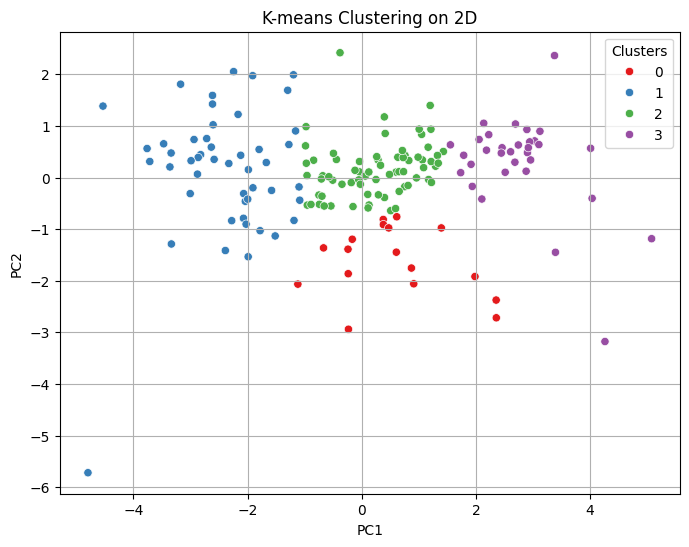

In [41]:
df_pca_2d["Clusters"] = best_labels
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca_2d, x='PC1', y='PC2', hue='Clusters', palette='Set1')
plt.title("K-means Clustering on 2D")
plt.grid(True)
plt.show()


Now, we run it back for 3 dimensions

In [43]:
X_pca_3d = X_np @ eigenvectors_sorted[:, :3]

df_pca_3d = pd.DataFrame(X_pca_3d, columns=['PC1', 'PC2', 'PC3'])

df_pca_3d

,PC1,PC2,PC3
0,-2.716300,0.756076,-0.923380
1,0.601770,0.106854,1.193895
2,-0.166475,-1.195099,0.754306
3,-3.335440,-1.286836,-1.060127
4,0.958376,-0.005687,0.820335
...,...,...,...
162,-0.971129,0.278057,0.716915
163,-0.232887,-2.939392,-0.177638
164,-0.024912,-0.129343,0.989478
165,-1.781273,-1.028974,-0.166467


pair wise scatter plots

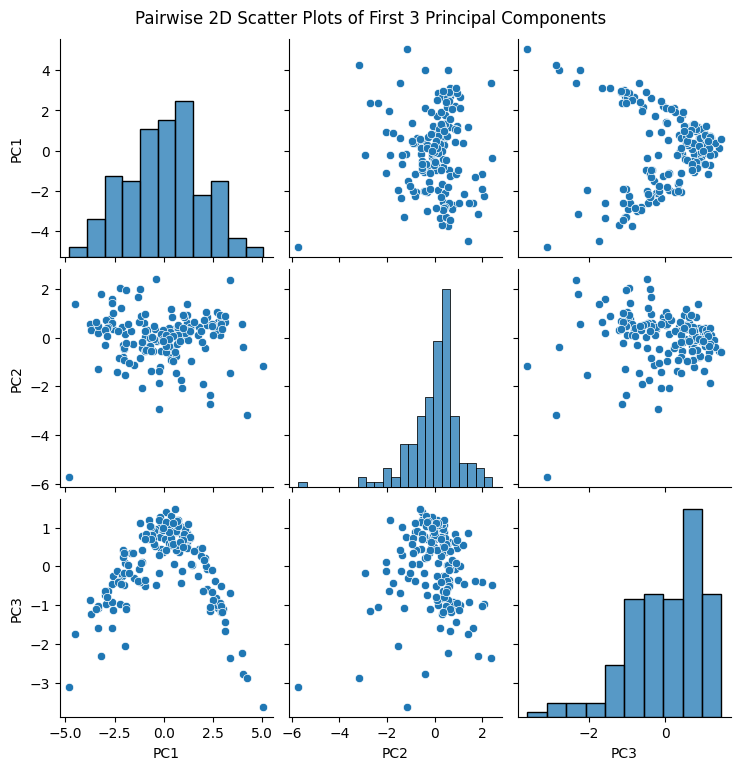

In [45]:
sns.pairplot(df_pca_3d)
plt.suptitle("Pairwise 2D Scatter Plots of First 3 Principal Components", y=1.02)
plt.show()

In [46]:
best_labels_3d = None
best_centroids_3d = None
lowest_distortion_3d = float('inf')

for i in range(5):
    print(f"\nInitialization {i+1}:")
    
    clusters, centroids = kmeans(X_pca_3d, k=4)
    

    
    # Show cluster labels for current run
    print("Cluster Labels:\n", clusters)
    
    # Show centroid coordinates for current run
    print("Centroids (in standardized feature space):\n", centroids)
    
    # Show distortion for current run
    distortion = compute_distortion(X_pca_3d, clusters, centroids) 
    print(f"Run {i+1} Distortion: {distortion:.2f}") 
    
    if distortion < lowest_distortion_3d: # min distortion calculation
        lowest_distortion_3d = distortion
        best_labels_3d = clusters
        best_centroids_3d = centroids

print("\n Best clustering selected with lowest distortion.")
best_labels_3d


Initialization 1:
Cluster Labels:
 [2 3 0 2 3 0 0 1 1 0 3 3 0 3 0 1 0 2 0 0 3 2 3 1 3 2 2 0 2 1 0 2 2 3 0 3 2
 2 2 3 2 3 3 3 1 0 3 0 3 2 2 3 0 1 1 2 2 3 1 2 3 3 0 2 2 0 2 3 1 0 0 0 2 1
 3 1 0 1 0 0 2 2 1 0 2 3 3 2 2 0 3 1 3 2 2 0 3 2 3 2 3 3 3 0 3 0 2 0 2 0 1
 1 2 2 1 0 2 3 0 0 0 3 3 1 3 0 2 0 0 2 3 3 2 1 3 3 2 2 3 1 0 0 2 0 1 1 0 2
 0 2 2 0 3 3 0 2 0 1 1 1 3 0 0 0 0 2 2]
Centroids (in standardized feature space):
 [[-0.21753569 -0.54381182  0.75836124]
 [ 2.99750834 -0.02815111 -1.26352274]
 [-2.38519254  0.21561717 -0.66244668]
 [ 1.07302894  0.38702464  0.62475753]]
Run 1 Distortion: 290.27

Initialization 2:
Cluster Labels:
 [3 0 0 3 0 0 0 2 2 0 2 0 0 0 0 2 0 3 0 0 0 3 0 2 0 3 3 0 3 2 0 3 3 0 0 0 3
 3 3 0 3 0 2 2 2 0 0 0 0 3 3 0 0 2 2 3 3 0 2 3 2 0 0 3 3 0 3 0 2 0 0 0 3 2
 2 2 0 2 0 0 3 3 2 0 3 0 0 3 3 0 0 1 0 3 3 0 0 3 2 3 0 0 0 0 0 0 3 0 3 0 2
 2 3 3 1 0 3 0 0 0 0 0 2 1 0 0 3 0 0 3 0 0 3 2 2 2 3 3 2 2 0 0 3 0 2 1 0 3
 0 3 3 0 0 0 0 3 0 2 2 2 0 0 0 0 0 3 3]
Centroids (in standard

array([2, 3, 0, 2, 3, 0, 0, 1, 1, 0, 3, 3, 0, 3, 0, 1, 0, 2, 0, 0, 3, 2,
       3, 1, 3, 2, 2, 0, 2, 1, 0, 2, 2, 3, 0, 3, 2, 2, 2, 3, 2, 3, 3, 3,
       1, 0, 3, 0, 3, 2, 2, 3, 0, 1, 1, 2, 2, 3, 1, 2, 3, 3, 0, 2, 2, 0,
       2, 3, 1, 0, 0, 0, 2, 1, 3, 1, 0, 1, 0, 0, 2, 2, 1, 0, 2, 3, 3, 2,
       2, 0, 3, 1, 3, 2, 2, 0, 3, 2, 3, 2, 3, 3, 3, 0, 3, 0, 2, 0, 2, 0,
       1, 1, 2, 2, 1, 0, 2, 3, 0, 0, 0, 3, 3, 1, 3, 0, 2, 0, 0, 2, 3, 3,
       2, 1, 3, 3, 2, 2, 3, 1, 0, 0, 2, 0, 1, 1, 0, 2, 0, 2, 2, 0, 3, 3,
       0, 2, 0, 1, 1, 1, 3, 0, 0, 0, 0, 2, 2])

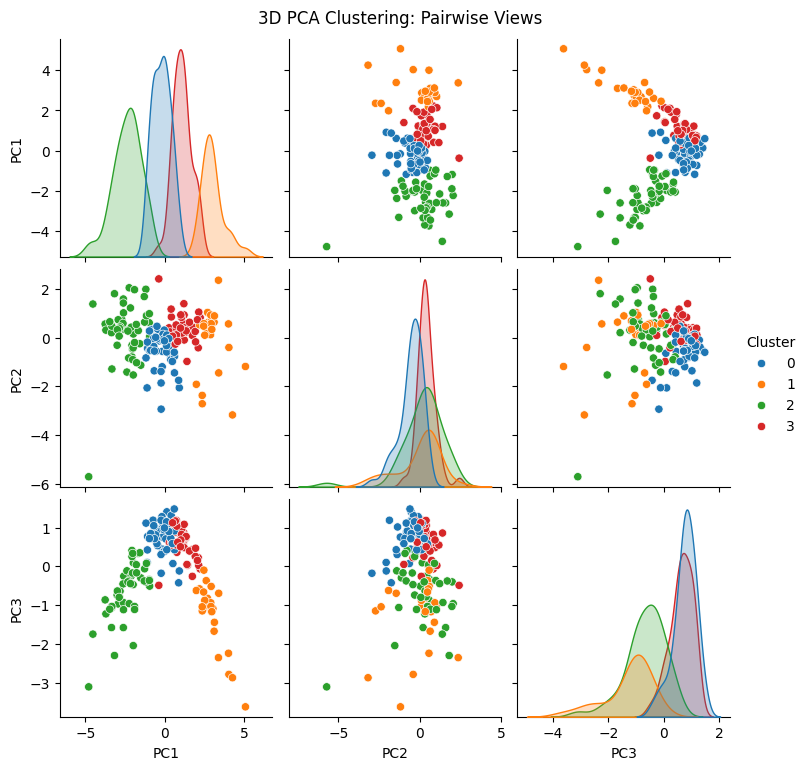

In [48]:
df_pca_3d["Cluster"]=best_labels_3d
sns.pairplot(df_pca_3d, hue='Cluster', palette='tab10')
plt.suptitle("3D PCA Clustering: Pairwise Views", y=1.02)
plt.show()
